# BCA Bank Stock Price Prediction

Source : Bursa Efek Indonesia [IDX](https://www.idx.co.id/id/perusahaan-tercatat/profil-perusahaan-tercatat/BBCA)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [74]:
data = pd.read_csv('BCA Bank Stock Data.csv',infer_datetime_format=True, index_col='Tanggal', header=0)
data.head()

C:\Users\fikri\AppData\Local\Temp\ipykernel_20340\1729197679.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('BCA Bank Stock Data.csv',infer_datetime_format=True, index_col='Tanggal', header=0)


,No,Harga Pembukaan,Tertinggi,Terendah,Penutupan,Volume,Nilai,Frekuensi
Tanggal,,,,,,,,
2025-02-17,1,8975,9325,8975,9325,89096400,818775542500,21925
2025-02-14,2,9000,9075,8950,8975,116274500,1044788057500,23400
2025-02-13,3,9100,9150,9000,9000,90439700,817617295000,20406
2025-02-12,4,8950,9150,8950,9150,121172600,1095997277500,27665
2025-02-11,5,9025,9100,9000,9075,71188300,644089892500,20196


In [75]:
data.drop(['No'], axis=1, inplace=True)

In [76]:
feature = data.shape[1]
feature

7

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2025-02-17 to 2021-01-04
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Harga Pembukaan  1000 non-null   int64
 1   Tertinggi        1000 non-null   int64
 2   Terendah         1000 non-null   int64
 3   Penutupan        1000 non-null   int64
 4   Volume           1000 non-null   int64
 5   Nilai            1000 non-null   int64
 6   Frekuensi        1000 non-null   int64
dtypes: int64(7)
memory usage: 62.5+ KB


In [78]:
data.duplicated().sum()

np.int64(0)

In [79]:
data.isnull().sum()

Harga Pembukaan    0
Tertinggi          0
Terendah           0
Penutupan          0
Volume             0
Nilai              0
Frekuensi          0
dtype: int64

In [80]:
data.describe()

,Harga Pembukaan,Tertinggi,Terendah,Penutupan,Volume,Nilai,Frekuensi
count,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,13437.350000,13549.025000,13310.87500,13427.500000,6.967406e+07,6.914510e+11,16929.935000
std,9454.329859,9525.588316,9334.60489,9426.366885,5.125710e+07,4.195958e+11,9661.540036
min,7025.000000,7100.000000,7000.00000,7000.000000,3.693000e+05,1.192530e+10,51.000000
25%,8368.750000,8475.000000,8318.75000,8375.000000,3.947152e+07,4.579200e+11,11096.500000
50%,9150.000000,9225.000000,9100.00000,9150.000000,6.348435e+07,6.147100e+11,14730.000000
75%,10300.000000,10350.000000,10200.00000,10300.000000,8.917465e+07,8.003948e+11,19443.250000
max,36725.000000,36900.000000,36225.00000,36725.000000,7.564316e+08,6.979013e+12,105454.000000


In [81]:
def outlier_check(df):
    outlier = {}
    for column in df.select_dtypes(include=np.number).columns:
        q25 , q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
        iqr = q75 - q25
        lower_outlier = q25 - 1.5 * iqr
        high_outlier = q75 + 1.5 * iqr
        outliers = df[(df[column] < lower_outlier) | (df[column] > high_outlier)][column]
        outlier[column] = len(outliers)
    total = sum(outlier.values())
    return outlier, total

price_outlier, total = outlier_check(data)
print(f"Total outlier in price data: {total}")
price_outlier

Total outlier in price data: 901


{'Harga Pembukaan': 192,
 'Tertinggi': 192,
 'Terendah': 192,
 'Penutupan': 192,
 'Volume': 28,
 'Nilai': 46,
 'Frekuensi': 59}

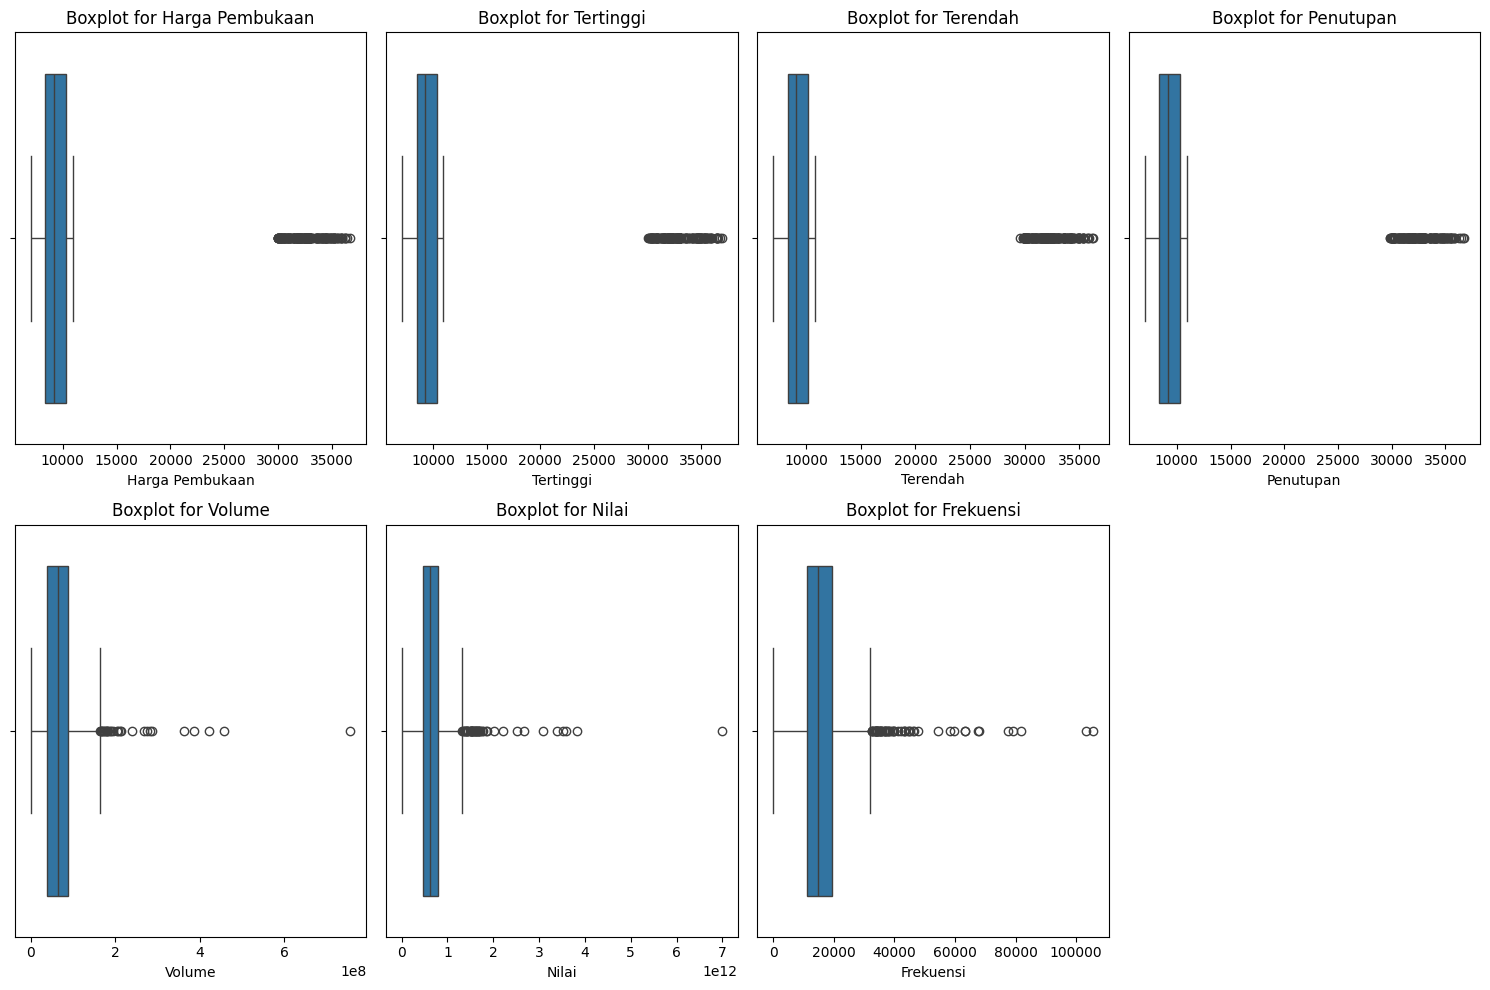

In [82]:
num_cols = data.select_dtypes(include=np.number).columns
n = len(num_cols)

rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for ax, col in zip(axes.flatten(), num_cols):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Boxplot for {col}')

for i in range(len(num_cols), rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [83]:
def remove_outliers(df):
    row_remove = set()
    for column in df.select_dtypes(include=np.number).columns:
        q25, q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
        iqr = q75 - q25
        lower_outlier = q25 - 1.5 * iqr
        high_outlier = q75 + 1.5 * iqr
        outlier = df[(df[column] < lower_outlier) | (df[column] > high_outlier)].index
        row_remove.update(outlier)
    cleaned_data = df.drop(index=row_remove)
    return cleaned_data

def print_outlier_summary(df, cleaned_data, dataset_name):
    rows_before = len(df)
    rows_after = len(cleaned_data)
    rows_removed = rows_before - rows_after
    print(f"Dataset: {dataset_name}")
    print(f"Number of rows before cleanup: {rows_before}")
    print(f"Number of rows deleted (containing outliers): {rows_removed}")
    print(f"Number of rows after cleanup: {rows_after}")
    print("-" * 50)

data_price_cleaned = remove_outliers(data)
print_outlier_summary(data, data_price_cleaned, "BCA Bank Stock Data.csv")

Dataset: BCA Bank Stock Data.csv
Number of rows before cleanup: 1000
Number of rows deleted (containing outliers): 272
Number of rows after cleanup: 728
--------------------------------------------------


In [84]:
data = data_price_cleaned
data.head()

,Harga Pembukaan,Tertinggi,Terendah,Penutupan,Volume,Nilai,Frekuensi
Tanggal,,,,,,,
2025-02-17,8975,9325,8975,9325,89096400,818775542500,21925
2025-02-14,9000,9075,8950,8975,116274500,1044788057500,23400
2025-02-13,9100,9150,9000,9000,90439700,817617295000,20406
2025-02-12,8950,9150,8950,9150,121172600,1095997277500,27665
2025-02-11,9025,9100,9000,9075,71188300,644089892500,20196


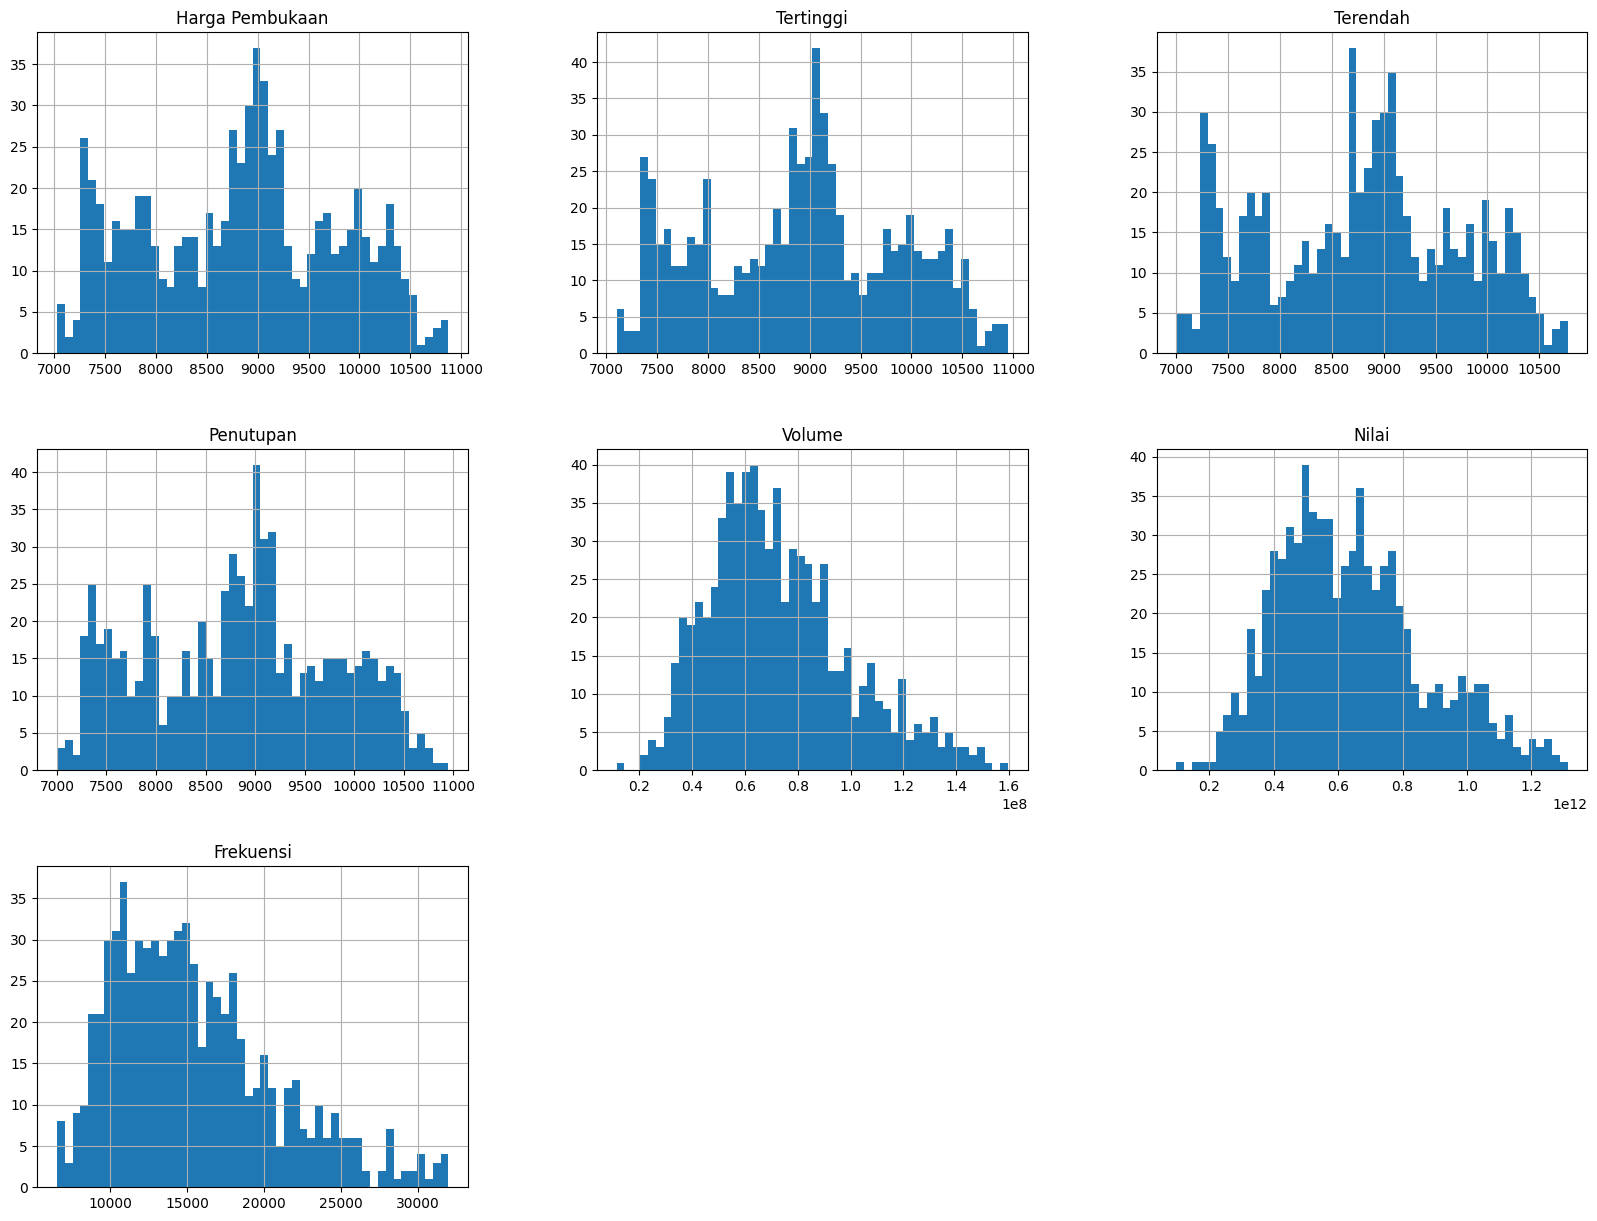

In [85]:
data.hist(bins=50, figsize=(20,15))
plt.show()

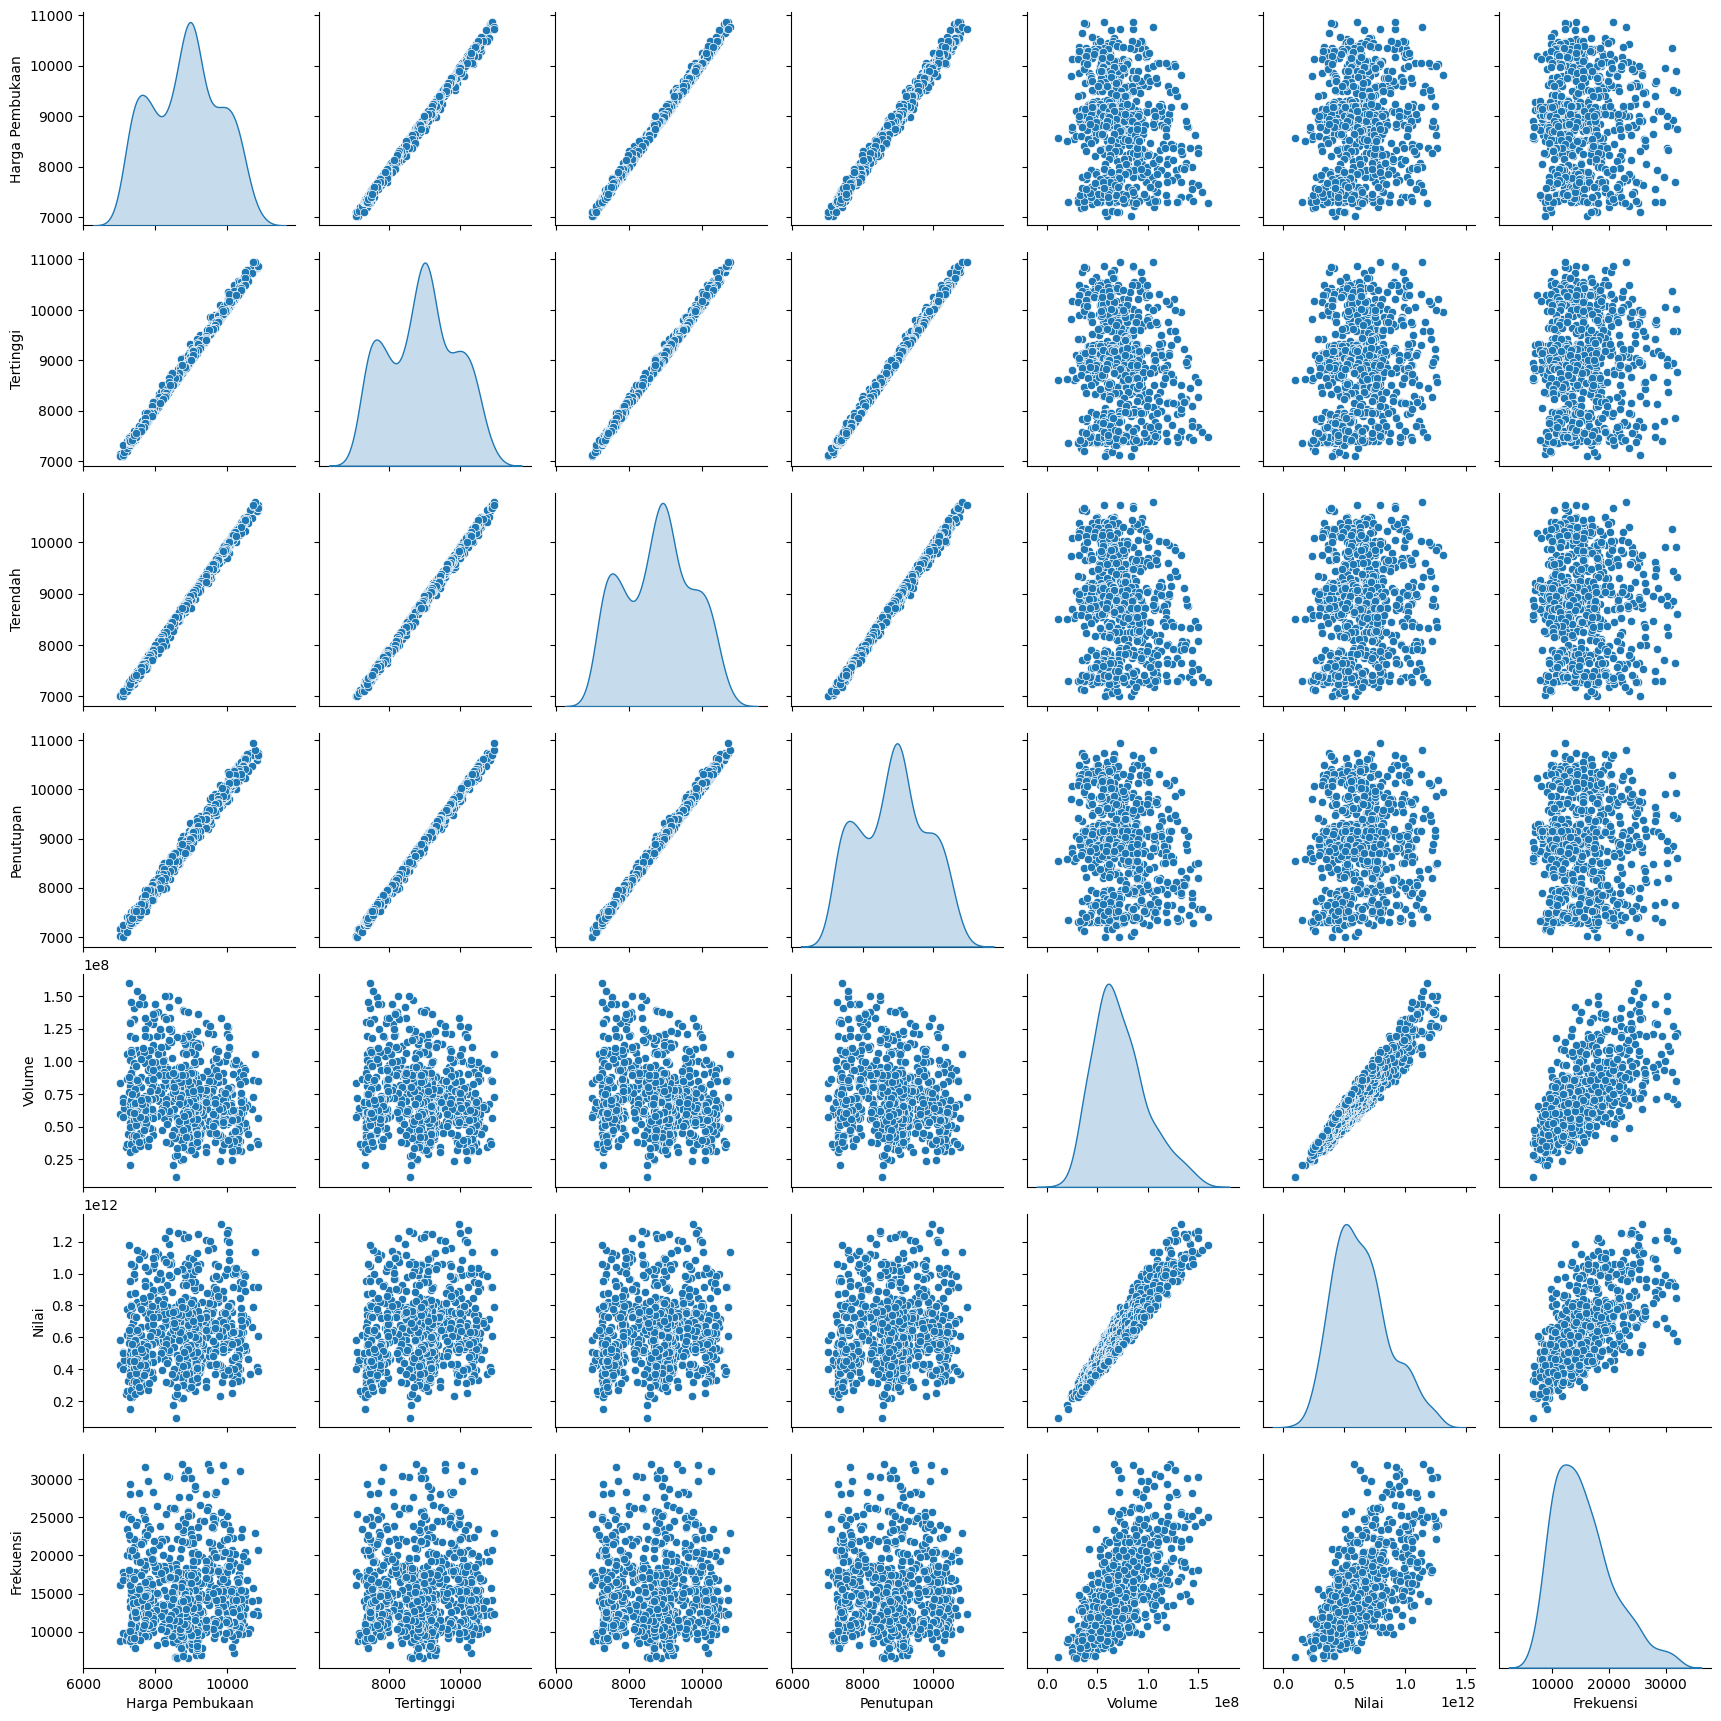

In [86]:
sns.pairplot(data, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

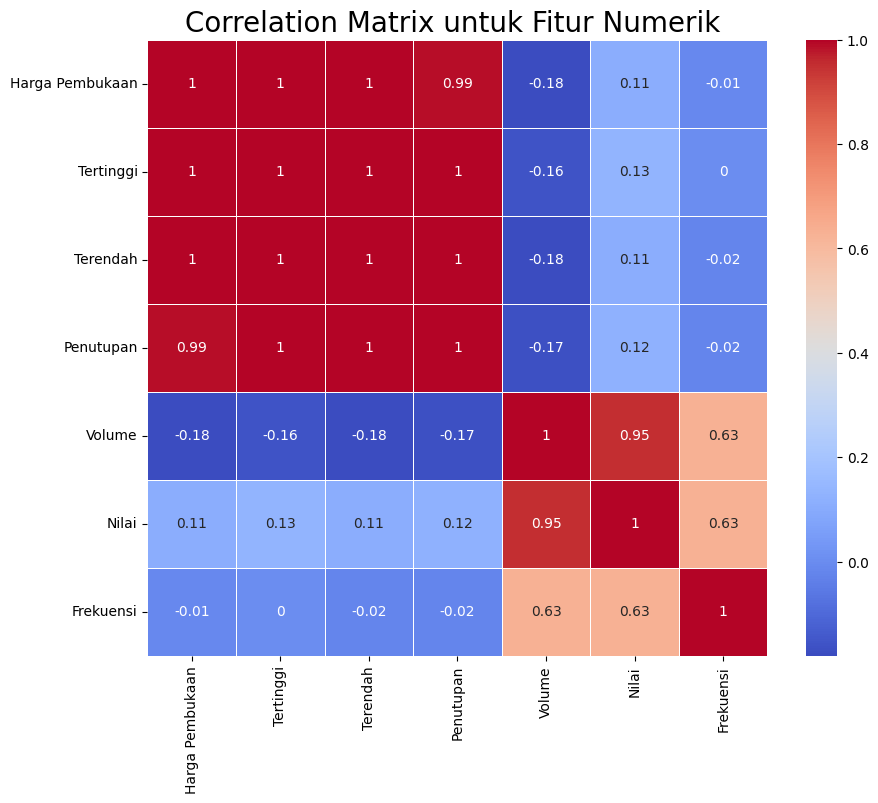

In [87]:
numerical_features = ['Harga Pembukaan', 'Tertinggi', 'Terendah', 'Penutupan', 'Volume', 'Nilai', 'Frekuensi']
plt.figure(figsize=(10, 8))
correlation_matrix = data[numerical_features].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

In [88]:
data = data.values
data

array([[         8975,          9325,          8975, ...,      89096400,
         818775542500,         21925],
       [         9000,          9075,          8950, ...,     116274500,
        1044788057500,         23400],
       [         9100,          9150,          9000, ...,      90439700,
         817617295000,         20406],
       ...,
       [         7600,          7600,          7500, ...,      70103000,
         529241822500,         17396],
       [         7400,          7525,          7400, ...,      60329800,
         451646792500,         16920],
       [         7450,          7550,          7425, ...,      96730700,
         727217982500,         23981]])

In [89]:
split_time =int(len(data)*0.8)

In [90]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0.50649351, 0.57792208, 0.52317881, ..., 0.5240327 , 0.59343303,
        0.60508501],
       [0.51298701, 0.51298701, 0.51655629, ..., 0.70736131, 0.77936967,
        0.66313759],
       [0.53896104, 0.53246753, 0.52980132, ..., 0.53309387, 0.59248016,
        0.54530069],
       ...,
       [0.14935065, 0.12987013, 0.13245033, ..., 0.3959136 , 0.35523859,
        0.42683407],
       [0.0974026 , 0.11038961, 0.10596026, ..., 0.32998894, 0.29140248,
        0.40809981],
       [0.11038961, 0.11688312, 0.11258278, ..., 0.57552952, 0.51811019,
        0.68600441]])

In [91]:
x_train = data[:split_time]
x_test = data[split_time:]

In [92]:
past = 7
future = 7

In [93]:
def create_windowed_dataset(data, past, future):
    X, y = [], []
    for i in range(len(data) - past - future):
        X.append(data[i:i+past].flatten())
        y.append(data[i+past:i+past+future].flatten())
    return np.array(X), np.array(y)

X_train, y_train = create_windowed_dataset(x_train, past, future)
X_test, y_test = create_windowed_dataset(x_test, past, future)

In [94]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
mse_rf_train = mean_squared_error(y_pred_train, y_train)
mse_rf_test = mean_squared_error(y_pred_test, y_test)
print(f"Random Forest MSE Train: {mse_rf_train}")
print(f"Random Forest MSE Test: {mse_rf_test}")

Random Forest MSE Train: 0.0021094584896407366
Random Forest MSE Test: 0.022243124780928502


In [95]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)
mse_lr_train = mean_squared_error(y_pred_train, y_train)
mse_lr_test = mean_squared_error(y_pred_test, y_test)
print(f"Linear Regression MSE Train: {mse_lr_train}")
print(f"Linear Regression MSE Test: {mse_lr_test}")

Linear Regression MSE Train: 0.013529036430233475
Linear Regression MSE Test: 0.02302775897089729


In [96]:
batch = 16
past = 7
future = 7
shift = 1

In [97]:
def windowed_dataset(series, batch_size, n_past, n_future, shift):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(n_past + n_future))
    data = data.shuffle(1000)
    data = data.map(lambda window: (window[:n_past], window[n_past:n_past + n_future]))
    data = data.batch(batch_size).prefetch(1)
    return data

train_dataset = windowed_dataset(x_train, batch, past, future, shift)
test_dataset = windowed_dataset(x_test, batch, past, future, shift)
for X_batch, y_batch in train_dataset.take(1):
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")

X_batch shape: (16, 7, 7)
y_batch shape: (16, 7, 7)


In [98]:
def model_lstm(past, feature, future):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(past, feature)),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=False),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(future * feature),
        tf.keras.layers.Reshape((future, feature))
    ])
    model.compile(optimizer='sgd', loss='mse')
    return model

lstm = model_lstm(past=7, feature=7, future=7)
lstm.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 7, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 49)             │         1,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 7, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,737 (479.44 KB)

 Trainable params: 122,737 (479.44 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
history_lstm = lstm.fit(train_dataset,
                        epochs=100,
                        validation_data=test_dataset
                      )

Epoch 1/100
     29/Unknown 2s 4ms/step - loss: 0.2861

C:\Users\fikri\PycharmProjects\Python Environments\Common Environment\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2849 - val_loss: 0.1048
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2747 - val_loss: 0.1011
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2674 - val_loss: 0.0975
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2527 - val_loss: 0.0942
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2556 - val_loss: 0.0910
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2477 - val_loss: 0.0879
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2390 - val_loss: 0.0850
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2290 - val_loss: 0.0822
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2173 - val_loss: 0.0795
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2196 - val_loss: 0.0769
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2142 - val_loss: 0.0745
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2093 - val_l

In [100]:
def model_lstm_cnn(past, feature, future):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(past, feature)),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(future * feature),
        tf.keras.layers.Reshape((future, feature))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_cnn = model_lstm_cnn(past=7, feature=7, future=7)
lstm_cnn.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 7, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 49)             │         1,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 7, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,377 (560.07 KB)

 Trainable params: 143,377 (560.07 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
history_lstm_cnn = lstm_cnn.fit(
    train_dataset.repeat(),
    epochs=100,
    steps_per_epoch=10,
    validation_data=test_dataset
)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2580 - val_loss: 0.0917
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2044 - val_loss: 0.0761
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1179 - val_loss: 0.0609
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0758 - val_loss: 0.0523
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0424 - val_loss: 0.0504
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - val_loss: 0.0465
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0260 - val_loss: 0.0473
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216 - val_loss: 0.0473
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0478
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238 - val_loss: 0.0480
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - val_loss: 0.0468
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [102]:
def model_gru(past, feature, future):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(past, feature)),
        tf.keras.layers.GRU(128, activation='relu', return_sequences=True),
        tf.keras.layers.GRU(64, activation='relu', return_sequences=False),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(future * feature),
        tf.keras.layers.Reshape((future, feature))
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

gru = model_gru(past=7, feature=7, future=7)
gru.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 7, 128)         │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 49)             │         1,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 7, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,713 (381.69 KB)

 Trainable params: 97,713 (381.69 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history_gru = gru.fit(
    train_dataset.repeat(),
    epochs=100,
    steps_per_epoch=10,
    validation_data=test_dataset
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.2725 - val_loss: 0.0906
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2015 - val_loss: 0.0777
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1444 - val_loss: 0.0577
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0975 - val_loss: 0.0488
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0611 - val_loss: 0.0458
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0351 - val_loss: 0.0458
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0268 - val_loss: 0.0458
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - val_loss: 0.0439
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - val_loss: 0.0428
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - val_loss: 0.0421
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197 - val_loss: 0.0417
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

In [104]:
def model_lstm_gru(past, feature, future):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(past, feature)),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.GRU(64, activation='relu', return_sequences=False),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(future * feature),
        tf.keras.layers.Reshape((future, feature))
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

lstm_gru = model_lstm_gru(past=7, feature=7, future=7)
lstm_gru.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 7, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 49)             │         1,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 7, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,737 (448.19 KB)

 Trainable params: 114,737 (448.19 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
history_lstm_gru = lstm_gru.fit(
    train_dataset.repeat(),
    epochs=100,
    steps_per_epoch=10,
    validation_data=test_dataset
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.2915 - val_loss: 0.0983
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2353 - val_loss: 0.0855
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1846 - val_loss: 0.0695
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1292 - val_loss: 0.0586
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0945 - val_loss: 0.0483
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0581 - val_loss: 0.0470
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0374 - val_loss: 0.0414
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0259 - val_loss: 0.0402
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0233 - val_loss: 0.0389
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199 - val_loss: 0.0363
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - val_loss: 0.0347
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

In [106]:
def model_bi_lstm(past, feature, future):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(past, feature)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(future * feature),
        tf.keras.layers.Reshape((future, feature))
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

bi_lstm = model_bi_lstm(past=7, feature=7, future=7)
bi_lstm.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 7, 256)         │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 49)             │         1,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 7, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,569 (1.20 MB)

 Trainable params: 315,569 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
history_bi_lstm = bi_lstm.fit(
    train_dataset.repeat(),
    epochs=100,
    steps_per_epoch=10,
    validation_data=test_dataset
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.2589 - val_loss: 0.0756
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1795 - val_loss: 0.0618
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1300 - val_loss: 0.0554
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0811 - val_loss: 0.0504
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0630 - val_loss: 0.0483
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0402 - val_loss: 0.0471
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - val_loss: 0.0477
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0329 - val_loss: 0.0467
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0334 - val_loss: 0.0473
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0335 - val_loss: 0.0450
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

In [111]:
mse_train_lstm = lstm.evaluate(train_dataset, verbose=0)
mse_test_lstm = lstm.evaluate(test_dataset, verbose=0)

print(f"MSE Train LSTM: {mse_train_lstm}")
print(f"MSE Test LSTM: {mse_test_lstm}")

MSE Train LSTM: 0.031825028359889984
MSE Test LSTM: 0.07963007688522339


In [113]:
mse_train_lstmcnn = lstm_cnn.evaluate(train_dataset, verbose=0)
mse_test_lstmcnn = lstm_cnn.evaluate(test_dataset, verbose=0)

print(f"MSE Train LSTM + CNN: {mse_train_lstmcnn}")
print(f"MSE Test LSTM + CNN: {mse_test_lstmcnn}")

MSE Train LSTM + CNN: 0.014963843859732151
MSE Test LSTM + CNN: 0.028775891289114952


In [114]:
mse_train_gru = gru.evaluate(train_dataset, verbose=0)
mse_test_gru = gru.evaluate(test_dataset, verbose=0)

print(f"MSE Train GRU: {mse_train_lstmcnn}")
print(f"MSE Test GRU: {mse_test_lstmcnn}")

MSE Train GRU: 0.014963843859732151
MSE Test GRU: 0.028775891289114952


In [115]:
mse_train_lstmgru = lstm_gru.evaluate(train_dataset, verbose=0)
mse_test_lstmgru = lstm_gru.evaluate(test_dataset, verbose=0)

print(f"MSE Train LSTM + GRU: {mse_train_lstmgru}")
print(f"MSE Test LSTM + GRU: {mse_test_lstmgru}")

MSE Train LSTM + GRU: 0.015358920209109783
MSE Test LSTM + GRU: 0.023699715733528137


In [116]:
mse_train_bilstm = bi_lstm.evaluate(train_dataset, verbose=0)
mse_test_bilstm = bi_lstm.evaluate(test_dataset, verbose=0)

print(f"MSE Train Bi-LSTM: {mse_train_bilstm}")
print(f"MSE Test Bi-LSTM: {mse_test_bilstm}")

MSE Train Bi-LSTM: 0.015274829231202602
MSE Test Bi-LSTM: 0.022663218900561333


In [117]:
mse_data_dl = {
    "Model": ["Linear Regression","Random Forest","LSTM", "LSTM + CNN", "GRU", "LSTM + GRU", "Bidirectional LSTM"],
    "MSE Train": [mse_lr_train, mse_rf_train, mse_train_lstm, mse_train_lstmcnn, mse_train_gru, mse_train_lstmgru, mse_train_bilstm],
    "MSE Test": [mse_lr_test, mse_rf_test, mse_test_lstm, mse_test_lstmcnn, mse_test_gru, mse_test_lstmgru, mse_test_bilstm]
}

mse_summary_model = pd.DataFrame(mse_data_dl)
mse_summary_model

,Model,MSE Train,MSE Test
0,Linear Regression,0.013529,0.023028
1,Random Forest,0.002109,0.022243
2,LSTM,0.031825,0.079630
3,LSTM + CNN,0.014964,0.028776
4,GRU,0.014714,0.027418
5,LSTM + GRU,0.015359,0.023700
6,Bidirectional LSTM,0.015275,0.022663
